In [1]:
## Standard libraries
import os
import random
import time
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Progress bar
from tqdm.notebook import tqdm

## Pytorch & Torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## Custom dataset
from CustomData import NFDataset
CSV_path =  ".\\Noise&Face_CSV\\"
indim = 128

In [2]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
#Set seed
set_seed(42)

In [3]:
#GPU check and setup
if torch.cuda.is_available():
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False
    
#Check for cuda GPU to run on:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
if gpu_avail:
    print("Device name: " + torch.cuda.get_device_name(0))

Is the GPU available? True
Device: cuda
Device name: NVIDIA GeForce GTX 1080 Ti


In [4]:
# Calc mean and std

test_transform =  transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((indim,indim)),
                                      transforms.ToTensor(),
                                     ])

dataset = NFDataset(csv_file = CSV_path+"NF_train.csv", root_dir = '.\\', transform = test_transform)
loader = DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=False, num_workers=4)

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(1)
    snd_moment = torch.empty(1)

    for images, _ in tqdm(loader):
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(loader)
print ("MEAN:", mean)
print ("STD:", std)

  0%|          | 0/146 [00:00<?, ?it/s]

MEAN: tensor([0.3120])
STD: tensor([0.2768])


In [5]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation((-180,180)),
                                      transforms.RandomResizedCrop((indim,indim),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                     ])
test_transform =  transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomRotation((-180,180)),
                                      transforms.Resize((indim,indim)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                     ])

# Split the sets
train_dataset = NFDataset(csv_file = CSV_path+"NF_train.csv", root_dir = '.\\', transform = train_transform)
val_dataset = NFDataset(csv_file = CSV_path+"NF_train.csv", root_dir = '.\\', transform = test_transform)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [14936,3734])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [14936,3734])
test_set = NFDataset(csv_file = CSV_path+"NF_test.csv", root_dir = '.\\', transform = test_transform)

# Define a set of data loaders
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(dataset=val_set, batch_size=128, shuffle=True, drop_last=False, num_workers=4)
test_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True, drop_last=False, num_workers=4)

Feature batch shape: torch.Size([128, 1, 128, 128])
Labels batch shape: torch.Size([128])


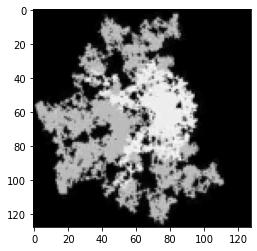

Label: 0


In [6]:
# Print a sample of the training data
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

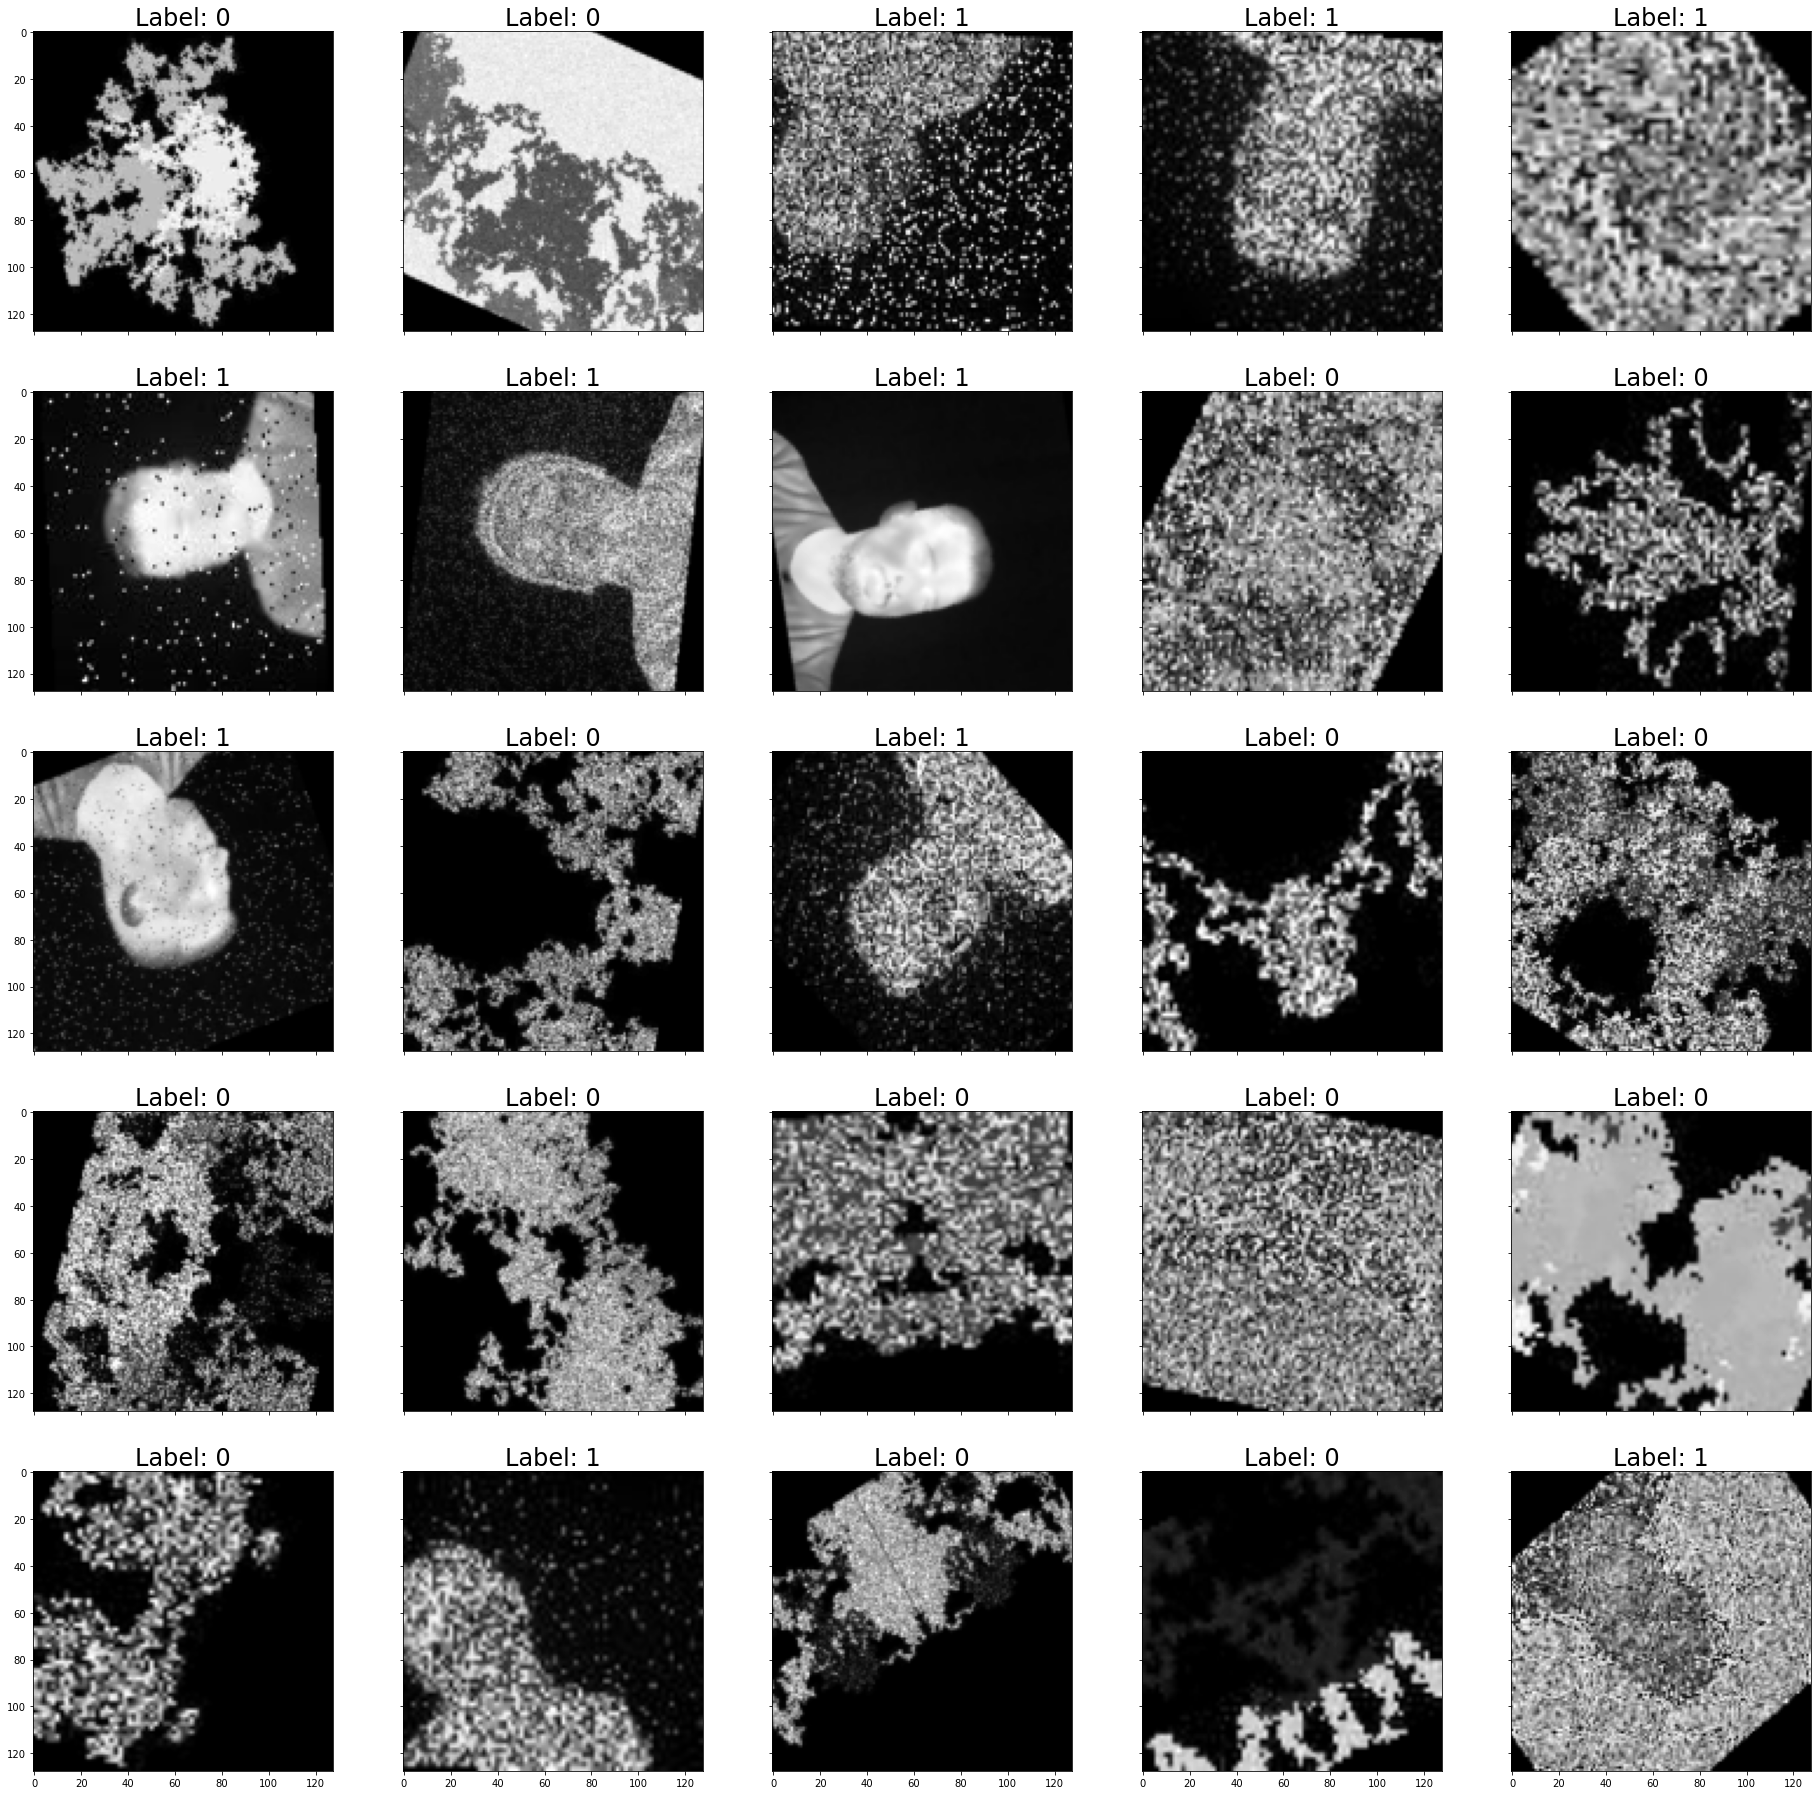

In [7]:
count = 0
l = 5
fig, axs = plt.subplots(l, l)
fig.set_figheight(32)
fig.set_figwidth(32)

for i in range(l):
    for j in range(l):
        img = train_features[count].squeeze()
        label = train_labels[count]

        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].set_title(f"Label: {label}", fontdict={'fontsize': 24})
        
        count +=1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [8]:
# To verify that our normalization works, we can print out the mean and standard deviation of the single batch.
# The mean should be close to 0 and the standard deviation close to 1 for each channel:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([-0.0156])
Batch std tensor([1.0412])


In [9]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(13456, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# defining the model
model = Net().to(device=device)

    
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
#Training and validation functions for first model:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
def test(model, test_loader):
    for name, loader in [("test", test_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [14]:
# defining the optimizer
#optimizer = Adam(model.parameters(), lr=0.07)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss().to(device=device)
    
training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

  0%|          | 0/300 [00:00<?, ?it/s]

2022-05-07 18:31:22.093702 Epoch 1, Training loss 0.17173931057211653
2022-05-07 18:32:53.140404 Epoch 10, Training loss 0.10176732118145146
2022-05-07 18:34:33.891593 Epoch 20, Training loss 0.09474769676232646
2022-05-07 18:36:14.584692 Epoch 30, Training loss 0.08271609208193319
2022-05-07 18:37:54.625691 Epoch 40, Training loss 0.07818235517961197
2022-05-07 18:39:35.037691 Epoch 50, Training loss 0.07270128949513209
2022-05-07 18:41:15.189691 Epoch 60, Training loss 0.06563786935896196
2022-05-07 18:42:55.553692 Epoch 70, Training loss 0.06049414033648269
2022-05-07 18:44:35.819691 Epoch 80, Training loss 0.061193786280486606
2022-05-07 18:46:16.156691 Epoch 90, Training loss 0.05467765615321696
2022-05-07 18:47:56.279691 Epoch 100, Training loss 0.04913899295256827
2022-05-07 18:49:36.703691 Epoch 110, Training loss 0.04663952077128764
2022-05-07 18:51:16.780691 Epoch 120, Training loss 0.042555481163335254
2022-05-07 18:52:58.247692 Epoch 130, Training loss 0.037430802143403684


In [13]:
test(model, test_loader)

Accuracy test: 0.94
